# Dataset Overview

## Firmware Import Metrics

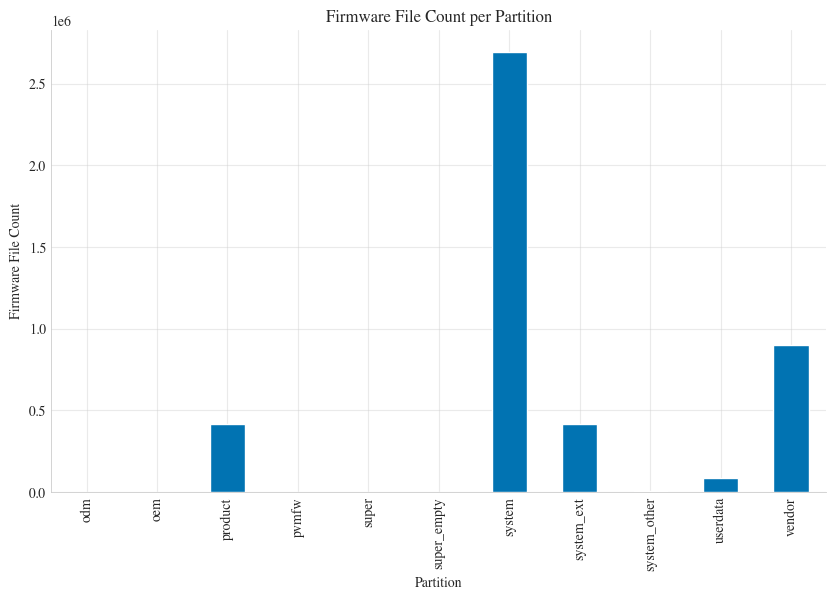

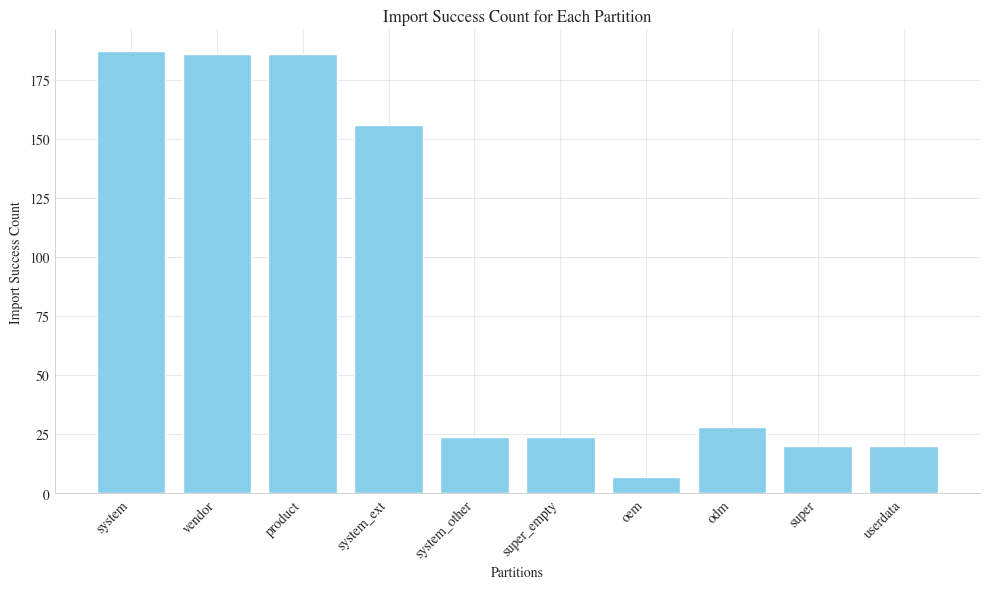

In [256]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

# Load the JSON data
with open('FirmwareDroid.android_firmware.json', 'r') as file:
    data = json.load(file)

# Flatten the JSON data for easier analysis
records = []
for item in data:
    filename = item['filename']
    for partition, details in item['partition_info_dict'].items():
        records.append({
            'filename': filename,
            'partition': partition,
            'is_import_success': details['is_import_success'],
            'firmware_file_count': details['firmware_file_count'],
            'android_app_count': details['android_app_count'],
            'build_prop_count': details['build_prop_count']
        })

df = pd.DataFrame(records)
# 1. Bar Chart: Firmware file count per partition
partition_firmware_counts = df.groupby('partition')['firmware_file_count'].sum()
partition_firmware_counts.plot(kind='bar', figsize=(10, 6), title='Firmware File Count per Partition')
plt.xlabel('Partition')
plt.ylabel('Firmware File Count')
plt.show()
# Initialize a dictionary to count import success for each partition
partition_success_count = defaultdict(int)

# Process the data
for item in data:
    partition_info = item.get("partition_info_dict", {})
    for partition, details in partition_info.items():
        if details.get("is_import_success", False):
            partition_success_count[partition] += 1

# Prepare data for the bar chart
partitions = list(partition_success_count.keys())
success_counts = list(partition_success_count.values())

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(partitions, success_counts, color='skyblue')
plt.xlabel('Partitions')
plt.ylabel('Import Success Count')
plt.title('Import Success Count for Each Partition')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()




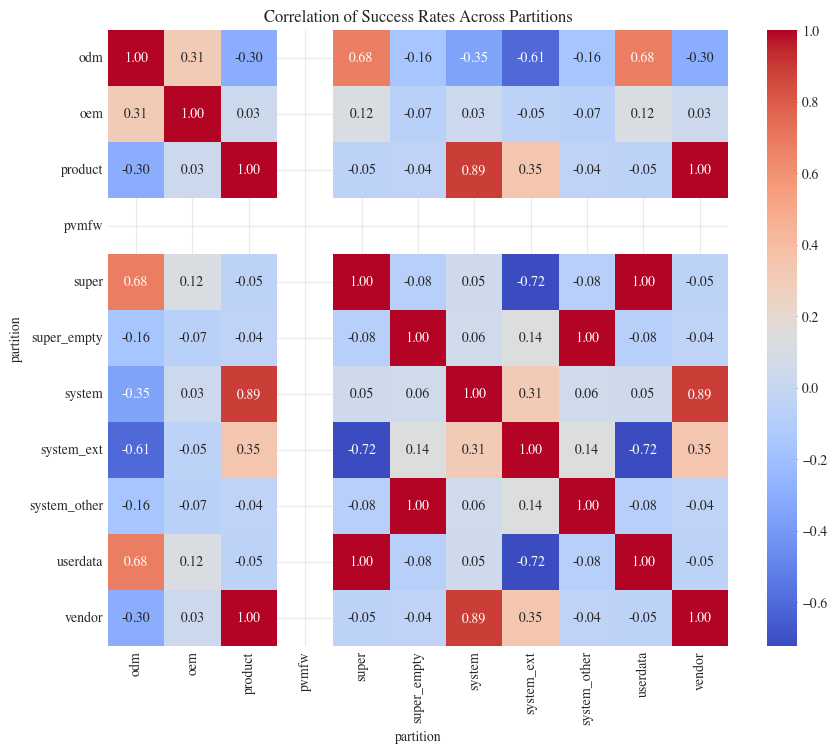

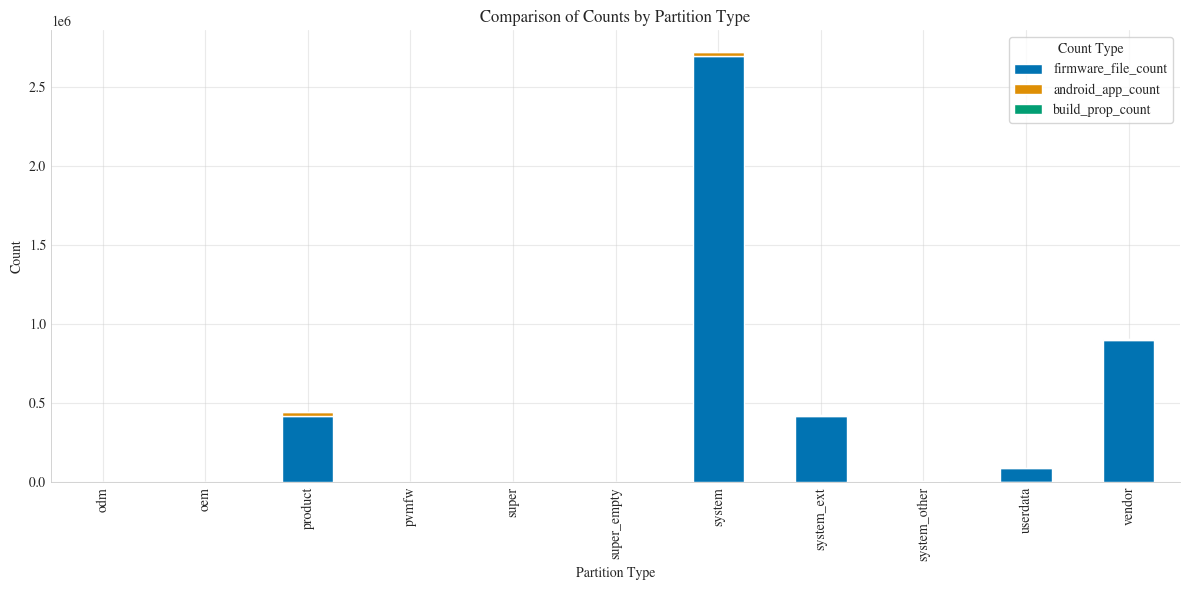

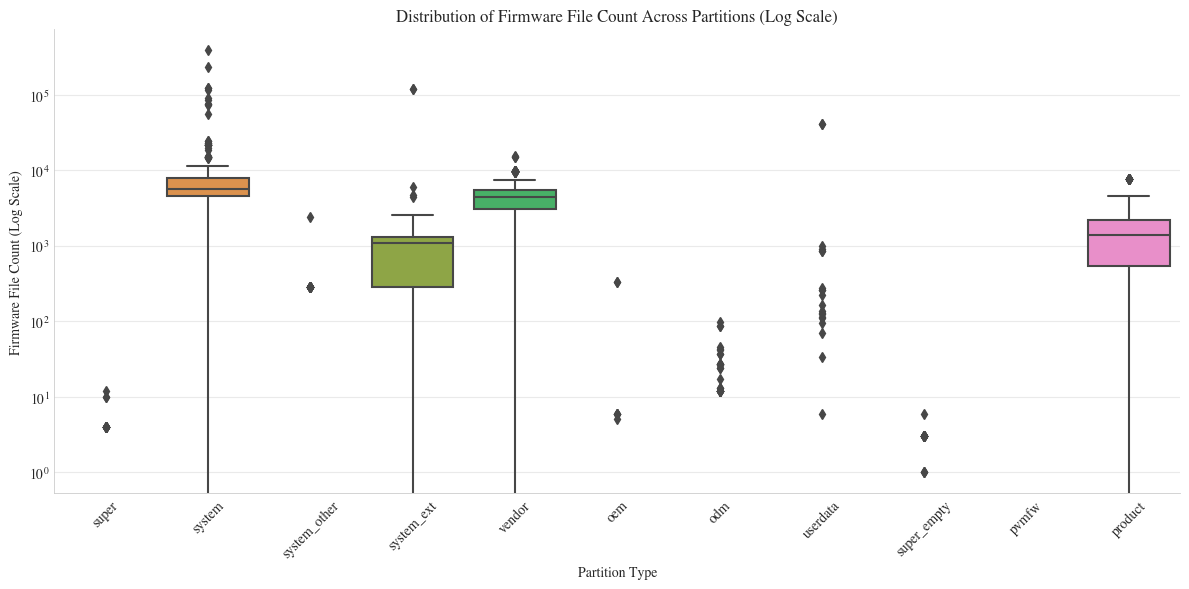

In [257]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Flatten the data into a DataFrame
records = []
for item in data:
    partition_info = item['partition_info_dict']
    for partition, details in partition_info.items():
        records.append({
            'filename': item['filename'],
            'partition': partition,
            'is_import_success': details['is_import_success'],
            'firmware_file_count': details['firmware_file_count'],
            'android_app_count': details['android_app_count'],
            'build_prop_count': details['build_prop_count']
        })

df = pd.DataFrame(records)

# Calculate success rate per partition
success_rate = df.groupby('partition')['is_import_success'].mean().reset_index()
success_rate.columns = ['partition', 'success_rate']

# Pivot for correlation
correlation_data = df.pivot_table(index='filename', columns='partition', values='is_import_success', aggfunc='mean')

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation of Success Rates Across Partitions')
plt.show()
# Flatten the data for easier processing
records = []
for item in data:
    for partition, values in item['partition_info_dict'].items():
        records.append({
            'filename': item['filename'],
            'partition': partition,
            'firmware_file_count': values['firmware_file_count'],
            'android_app_count': values['android_app_count'],
            'build_prop_count': values['build_prop_count']
        })

df = pd.DataFrame(records)

# Stacked Bar Chart
partition_sums = df.groupby('partition')[['firmware_file_count', 'android_app_count', 'build_prop_count']].sum()
partition_sums.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Comparison of Counts by Partition Type')
plt.ylabel('Count')
plt.xlabel('Partition Type')
plt.legend(title='Count Type')
plt.tight_layout()
plt.show()
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='partition', y='firmware_file_count')
plt.yscale('log')  # Set y-axis to log scale
plt.title('Distribution of Firmware File Count Across Partitions (Log Scale)')
plt.ylabel('Firmware File Count (Log Scale)')
plt.xlabel('Partition Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



## Firmware Meta-Data Analysis

In [258]:
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
import json
import base64
import pandas as pd
import seaborn as sns

# Load the JSON file
# "test.json"
#with open('FirmwareDroid.build_properties.json', 'r') as file:
#   # data = json.load(file)
#    data_dict = {"build_property_file_list": []}
#    android_firmware_list = data['data']['android_firmware_list']
#    # Flatten the data into a better structure
#    for item_dict in android_firmware_list:
#        build_property_dict = item_dict["buildPropFileIdList"]
#        firmware_id_base64 = item_dict["id"]
#        decoded_bytes = base64.b64decode(firmware_id_base64)
#        firmware_id = decoded_bytes.decode("utf-8").split(":")[1]
#        file_dict = {"firmware_id": firmware_id, "build_properties": {}}
#        for edge_list in build_property_dict.values():
 #           for node in edge_list:
#                properties_dict = json.loads(node["node"]["properties"])
#                for key, value in properties_dict.items():
#                    file_dict["build_properties"][key] = value
#        data_dict["build_property_file_list"].append(file_dict)


with open('FirmwareDroid.build_props_v3.json', 'r') as file:
    data = json.load(file)
    data_dict = {"build_property_file_list": []}
    android_firmware_list = data['data']['build_prop_file_id_list']
    for node in android_firmware_list:
        print(node)
        build_property_id = node["pk"]
        firmware_id = node["firmwareIdReference"]["pk"]
        file_dict = {"build_property_id": build_property_id, "firmware_id": firmware_id, "build_properties": {}}
        build_properties = node["properties"]
        properties_dict = json.loads(build_properties)
        for key, value in properties_dict.items():
            file_dict["build_properties"][key] = value
        data_dict["build_property_file_list"].append(file_dict)

    #print(data_dict)

def get_all_keys():
    all_keys = set()
    for firmware_entry in data_dict['build_property_file_list']:
        for key in firmware_entry['build_properties'].keys():
            all_keys.add(key)
    return list(all_keys)

def get_frequencies(target_key):
    frequency_dict = {}
    for firmware_entry in data_dict['build_property_file_list']:
        if target_key not in frequency_dict:
            frequency_dict[target_key] = []

        if target_key in firmware_entry['build_properties']:
            value = firmware_entry['build_properties'][target_key]
            value = value.capitalize()
            frequency_dict[target_key].append(value)
        else:
            # Handle specific cases for missing keys of brand naming of the system key. Adding the vendor brand if available.
            if target_key == "ro_product_system_brand" and "ro_product_vendor_brand" in firmware_entry['build_properties']:
                value = firmware_entry['build_properties']["ro_product_vendor_brand"]
                value = value.capitalize()
                if "ro_product_vendor_brand" not in frequency_dict:
                    frequency_dict["ro_product_vendor_brand"] = []
                frequency_dict["ro_product_vendor_brand"].append(value)
            elif target_key == "ro_product_system_brand" and "ro_product_odm_manufacturer" in firmware_entry['build_properties']:
                value = firmware_entry['build_properties']["ro_product_odm_manufacturer"]
                value = value.capitalize()
                if "ro_product_odm_manufacturer" not in frequency_dict:
                    frequency_dict["ro_product_odm_manufacturer"] = []
                frequency_dict["ro_product_odm_manufacturer"].append(value)
            else:
                if target_key == "ro_product_system_brand":
                    print(f"Key '{target_key}' not found in firmware entry: {firmware_entry['firmware_id']}")
                frequency_dict[target_key].append("N/A")
    return frequency_dict

def get_all_frequencies():
    frequency_dict = {}
    all_keys = get_all_keys()
    for key in all_keys:
        frequency_dict[key] = get_frequencies(key)[key]
    return frequency_dict

def plot_frequency(value_list, title=None, output_file=None, x_title="Values", y_title="Frequency"):
    property_counts = Counter(value_list)

    # Use seaborn to set the style and color palette
    sns.set_style('whitegrid')
    sns.set_palette('colorblind')  # Use a colorblind-friendly palette
    fig, ax = plt.subplots(figsize=(8, 6))  # Adjust figure size for better readability

    # Plot the frequency
    bars = ax.bar(property_counts.keys(), property_counts.values(), color=sns.color_palette('colorblind'), edgecolor='black')
    ax.set_xlabel(x_title, fontsize=14)
    ax.set_ylabel(y_title, fontsize=14)
    ax.tick_params(axis='both', labelsize=12)
    if title:
        ax.set_title(title, fontsize=16, weight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    # Add numbers on top of the bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height}', ha='center', va='bottom', fontsize=10)

    # Save the plot as a PDF if output_file is provided
    if output_file:
        plt.savefig(output_file, format='pdf', bbox_inches='tight', dpi=300)  # High resolution for publication

    plt.show()

frequency_dict = get_all_frequencies()
#print(frequency_dict)


{'firmwareIdReference': {'pk': '68af0f3e65e2ad36cf732fc8', 'id': 'QW5kcm9pZEZpcm13YXJlVHlwZTo2OGFmMGYzZTY1ZTJhZDM2Y2Y3MzJmYzg='}, 'pk': '68af0d9865e2ad36cf718126', 'id': 'QnVpbGRQcm9wRmlsZVR5cGU6NjhhZjBkOTg2NWUyYWQzNmNmNzE4MTI2', 'properties': '{"ro_product_system_brand": "google", "ro_product_system_device": "generic", "ro_product_system_manufacturer": "Google", "ro_product_system_model": "mainline", "ro_product_system_name": "mainline", "ro_system_product_cpu_abilist": "arm64-v8a,armeabi-v7a,armeabi", "ro_system_product_cpu_abilist32": "armeabi-v7a,armeabi", "ro_system_product_cpu_abilist64": "arm64-v8a", "ro_system_build_date": "Wed Jun  1 23:25:36 UTC 2022", "ro_system_build_date_utc": "1654125936", "ro_system_build_fingerprint": "google/oriole/oriole:12/SQ3A.220705.003.A1/8672226:user/release-keys", "ro_system_build_id": "SQ3A.220705.003.A1", "ro_system_build_tags": "release-keys", "ro_system_build_type": "user", "ro_system_build_version_incremental": "8672226", "ro_system_build_v

In [259]:
from collections import defaultdict
# defaultdict makes it easier to append firmware_ids
sdk_versions_dict = defaultdict(list)

for entry in data_dict['build_property_file_list']:
    fw_id = entry["firmware_id"]
    sdk_version = entry["build_properties"].get("ro_build_version_sdk")

    if sdk_version:
        sdk_versions_dict[sdk_version].append(fw_id)

# If you want a plain dict instead of defaultdict
sdk_versions_dict = dict(sdk_versions_dict)

print(sdk_versions_dict)

{'32': ['68af0f3e65e2ad36cf732fc8', '68af0f0865e2ad36cf731949', '68afa63065e2ad36cff0e277', '68afc71965e2ad36cf0c4584', '68b00a1665e2ad36cf430442', '68b014e565e2ad36cf4b16c5', '68b0650765e2ad36cf8e8100', '68b0f76c65e2ad36cffc4271', '68b1259c65e2ad36cf1f93fb', '68b13c0765e2ad36cf3046f8', '68b1577465e2ad36cf46a434', '68b15e7865e2ad36cf4b1435', '68b1cdb665e2ad36cfa30dbb', '68b1d3db65e2ad36cfa89938', '68b1e78065e2ad36cfb8a415', '68b1f27165e2ad36cfc1979b', '68b200c865e2ad36cfcc7b51', '68b214e665e2ad36cfdd617a', '68b2234d65e2ad36cfe68aa8', '68b231bb65e2ad36cff19010', '68b240b465e2ad36cfff9375', '68b25dc465e2ad36cf15ce8d', '68b2bc4c65e2ad36cf594a18', '68b2c8b265e2ad36cf61f56b', '68b2e79465e2ad36cf7b303e', '68b308e265e2ad36cf948f21'], '31': ['68af110965e2ad36cf7475cd', '68af163465e2ad36cf783058', '68af169465e2ad36cf7871b7', '68af219965e2ad36cf8260b2', '68af271f65e2ad36cf87f7a9', '68af2c8865e2ad36cf8d7c82', '68af2f0565e2ad36cf8ec78b', '68af388565e2ad36cf94dea9', '68af426d65e2ad36cf9f9ae2', '68a

In [260]:
allowed_sdks = {"31", "32", "33"}

# Split into kept and removed entries
kept_entries = []
removed_entries = []


for e in data_dict['build_property_file_list']:
    if e["build_properties"].get("ro_build_version_sdk") in allowed_sdks:
        kept_entries.append(e)
    else:
        removed_entries.append(e)

print(f"Number of entries removed: {len(removed_entries)}")
print("Removed entries:")
for e in removed_entries:
    print(e["firmware_id"])

print(f"\nNumber of entries remaining: {len(kept_entries)}")
print("Remaining entries:")
list_31 = set()
list_32 = set()
list_33 = set()


Number of entries removed: 8
Removed entries:
68af32be65e2ad36cf9119d6
68af480965e2ad36cfa428bd
68af6b4365e2ad36cfbe3fd0
68b0beb765e2ad36cfcc912f
68b0cf5465e2ad36cfdb2af2
68b2160565e2ad36cfddb0fc
68b2e0d965e2ad36cf7404db
68b2f8dc65e2ad36cf87b267

Number of entries remaining: 280
Remaining entries:


In [261]:
for e in kept_entries:
    #print(e["firmware_id"])
    if e["build_properties"].get("ro_build_version_sdk") == "31":
        list_31.add(e["firmware_id"])
    elif e["build_properties"].get("ro_build_version_sdk") == "32":
        list_32.add(e["firmware_id"])
    elif e["build_properties"].get("ro_build_version_sdk") == "33":
        list_33.add(e["firmware_id"])

print(f"Len 31: {len(list_31)}")
print(f"Len 32: {len(list_32)}")
print(f"Len 33: {len(list_33)}")

Len 31: 110
Len 32: 26
Len 33: 144


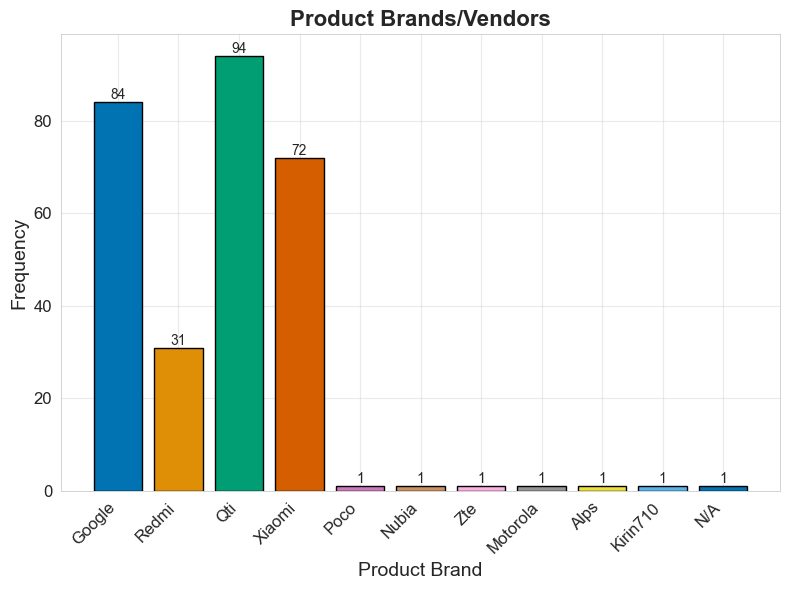

In [262]:
plot_frequency(frequency_dict["ro_product_system_brand"], title="Product Brands/Vendors", x_title="Product Brand", output_file="./images/Dataset_brand_manufacturer_mixed.pdf")

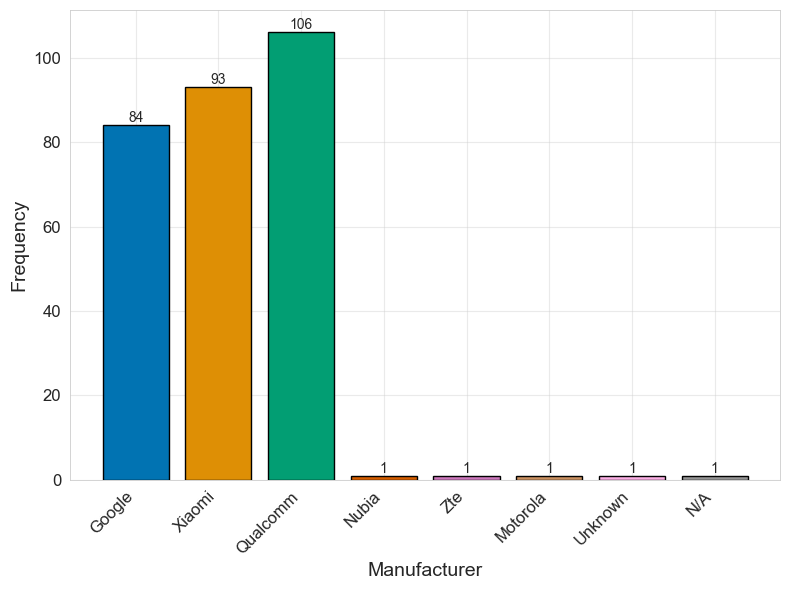

In [263]:
plot_frequency(frequency_dict["ro_product_system_manufacturer"], title=None, x_title="Manufacturer", output_file="./images/Dataset_ro_product_system_manufacturer.pdf")

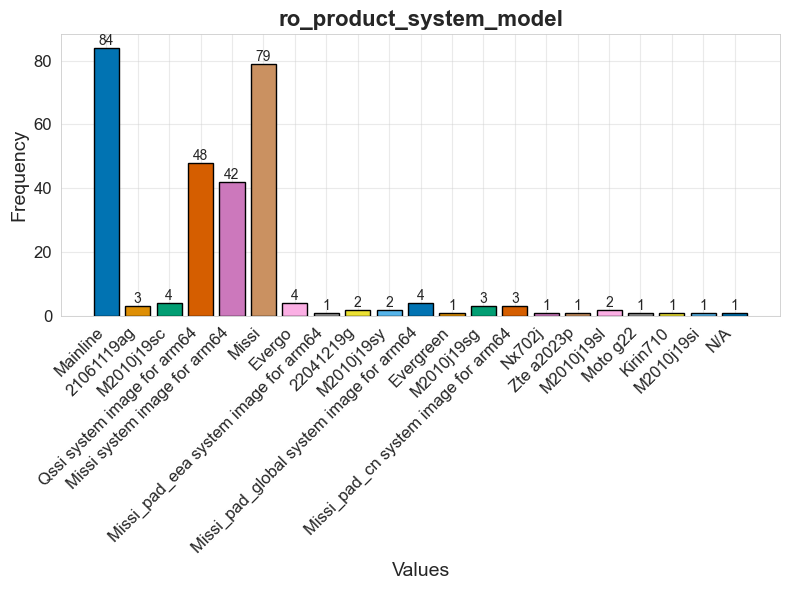

In [264]:
plot_frequency(frequency_dict["ro_product_system_model"], title="ro_product_system_model")

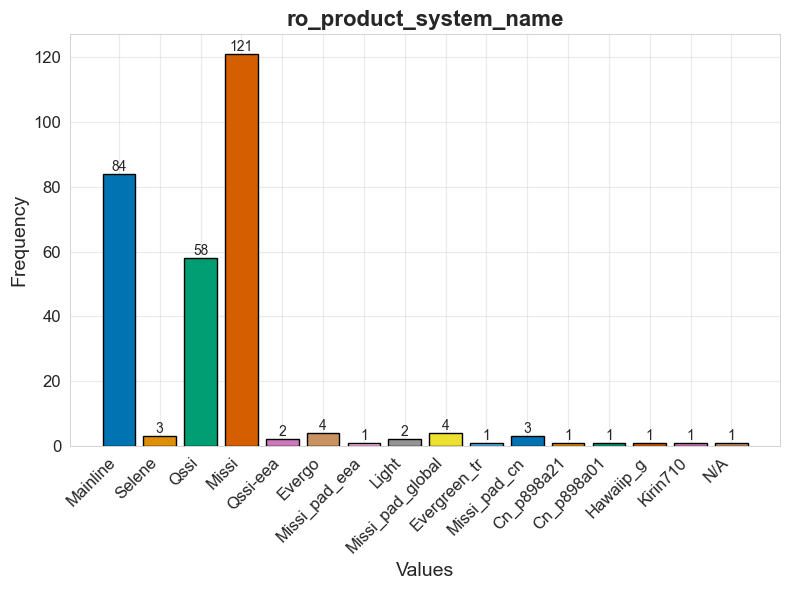

In [265]:
plot_frequency(frequency_dict["ro_product_system_name"], title="ro_product_system_name")

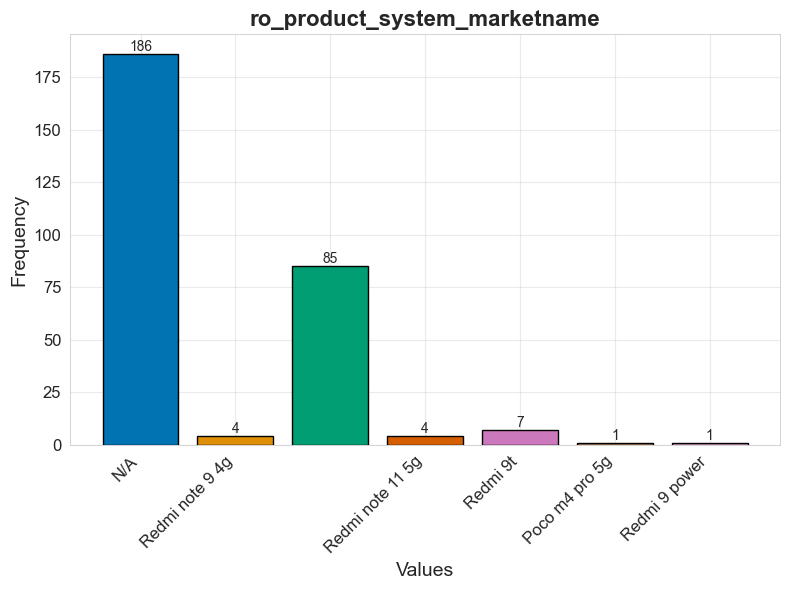

In [266]:
try:
    plot_frequency(frequency_dict["ro_product_system_marketname"], title="ro_product_system_marketname")
except Exception as e:
    print(e)

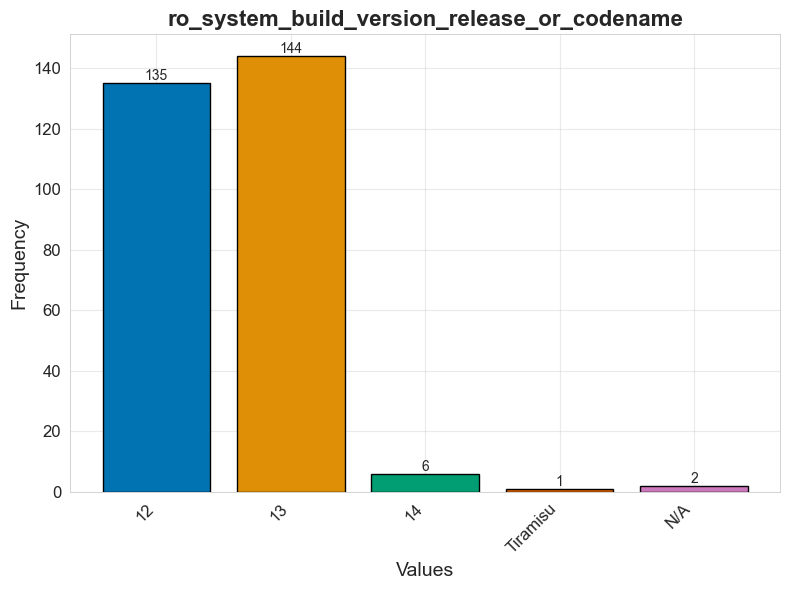

In [267]:
plot_frequency(frequency_dict["ro_system_build_version_release_or_codename"], title="ro_system_build_version_release_or_codename")

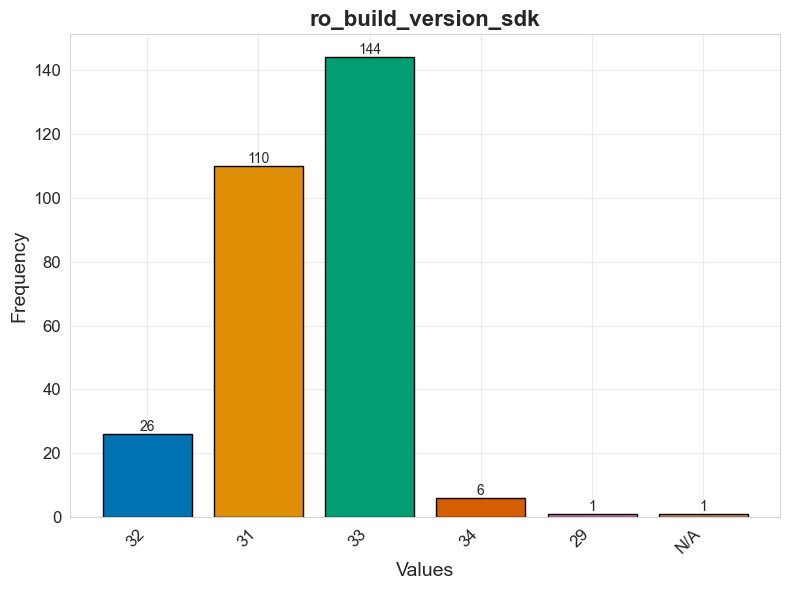

In [268]:
plot_frequency(frequency_dict["ro_build_version_sdk"], title="ro_build_version_sdk")

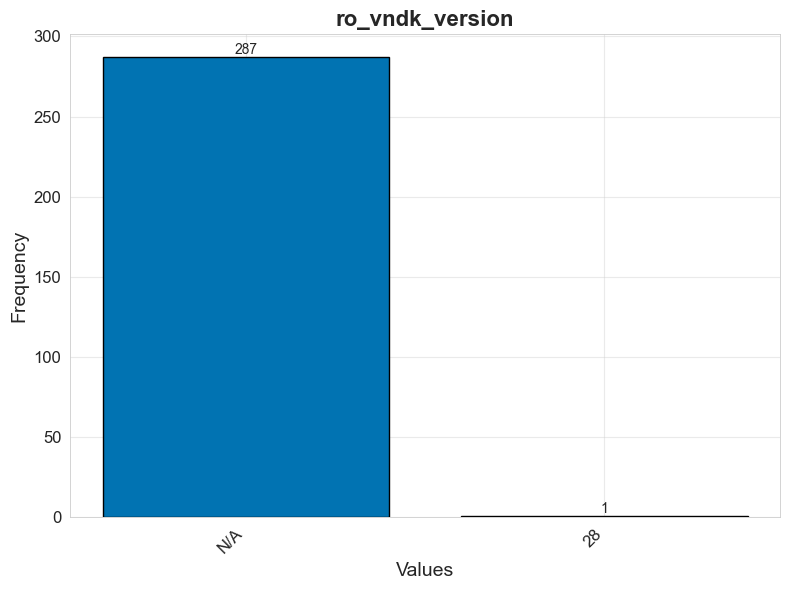

In [269]:
try:
    plot_frequency(frequency_dict["ro_vndk_version"], title="ro_vndk_version")
except Exception as e:
    print(e)

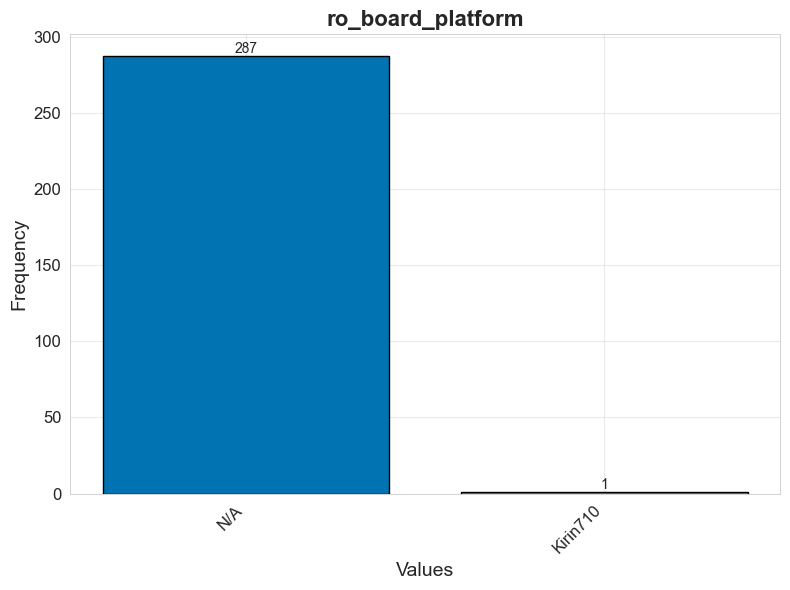

In [270]:
try:
    plot_frequency(frequency_dict["ro_board_platform"], title="ro_board_platform")
except Exception as e:
    print(e)

In [271]:
try:
    plot_frequency(frequency_dict["ro_board_api_level"], title="ro_board_api_level")
except Exception as e:
    print(e)

'ro_board_api_level'


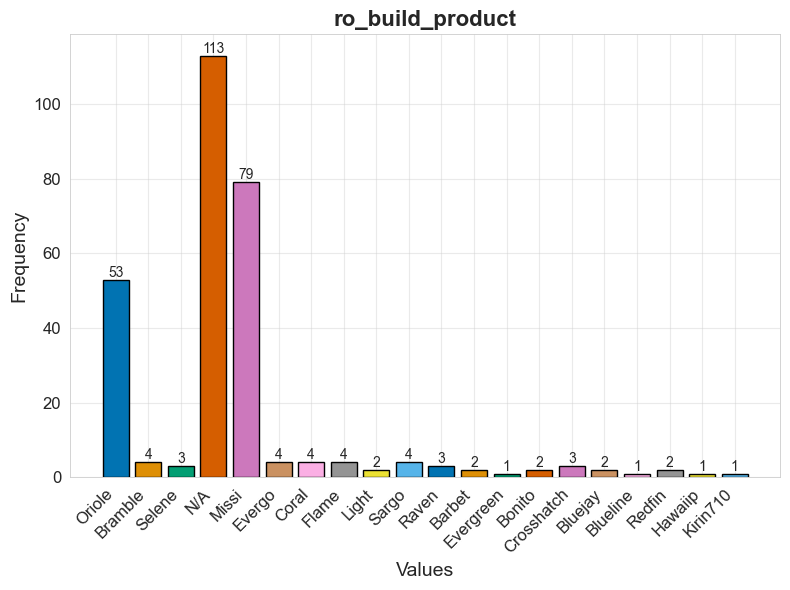

In [272]:
try:
    plot_frequency(frequency_dict["ro_build_product"], title="ro_build_product")
except Exception as e:
    print(e)

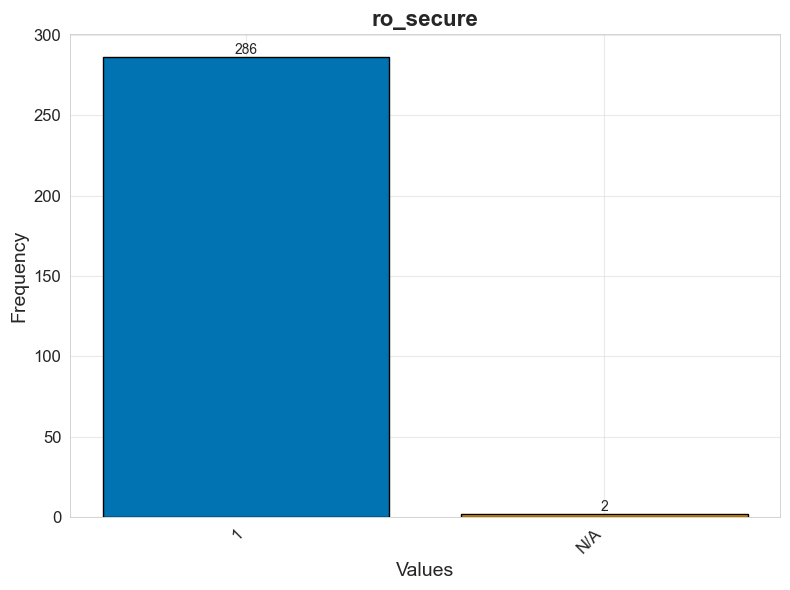

In [273]:
try:
    plot_frequency(frequency_dict["ro_secure"], title="ro_secure")
except Exception as e:
    print(e)

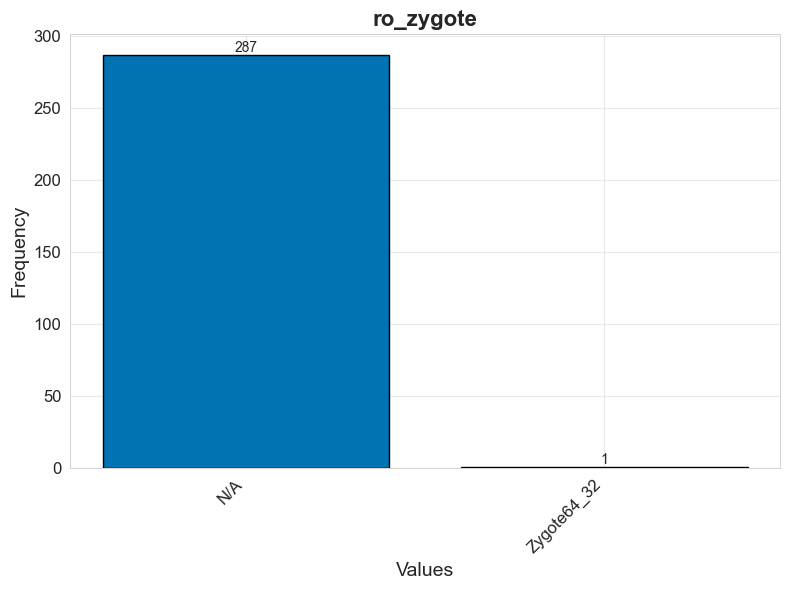

In [274]:
try:
    plot_frequency(frequency_dict["ro_zygote"], title="ro_zygote")
except Exception as e:
    print(e)

In [275]:
try:
    plot_frequency(frequency_dict["ro_product_build_tags"], title="ro_product_build_tags")
except Exception as e:
    print(e)

'ro_product_build_tags'


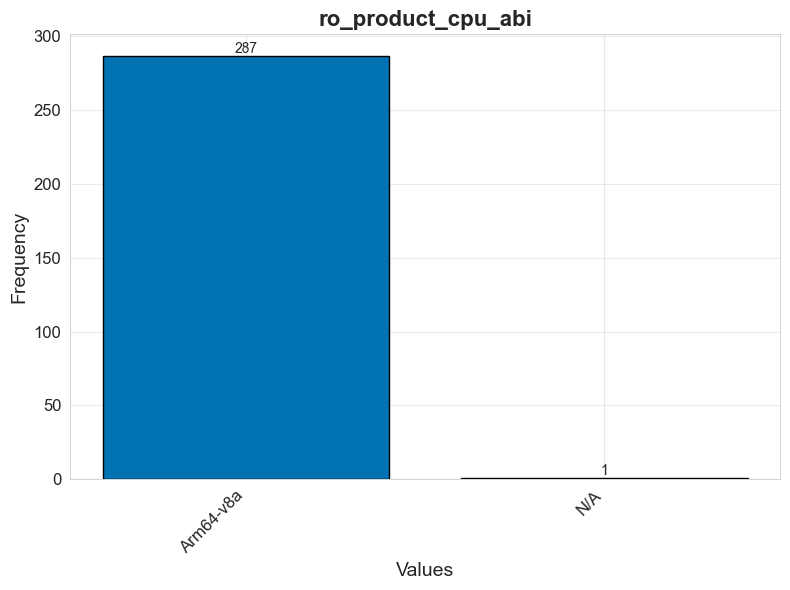

In [276]:
try:
    plot_frequency(frequency_dict["ro_product_cpu_abi"], title="ro_product_cpu_abi")
except Exception as e:
    print(e)

# Re-Hosting Performance Evaluation

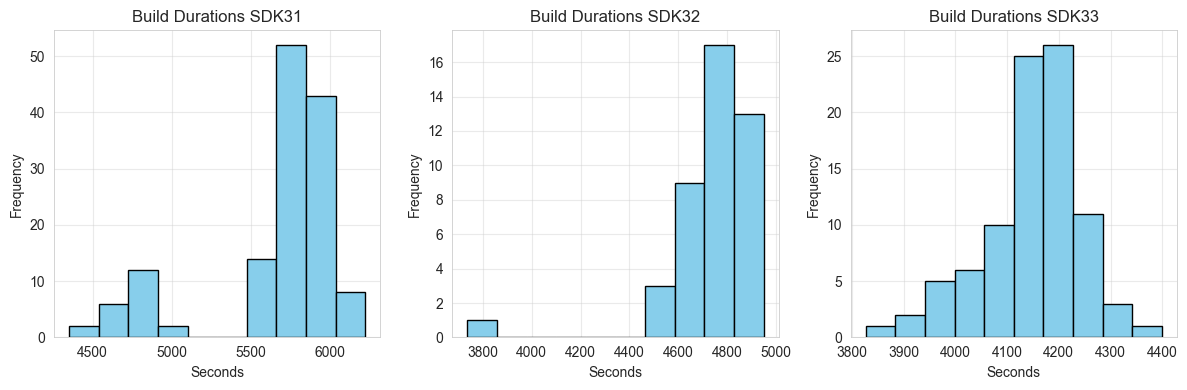

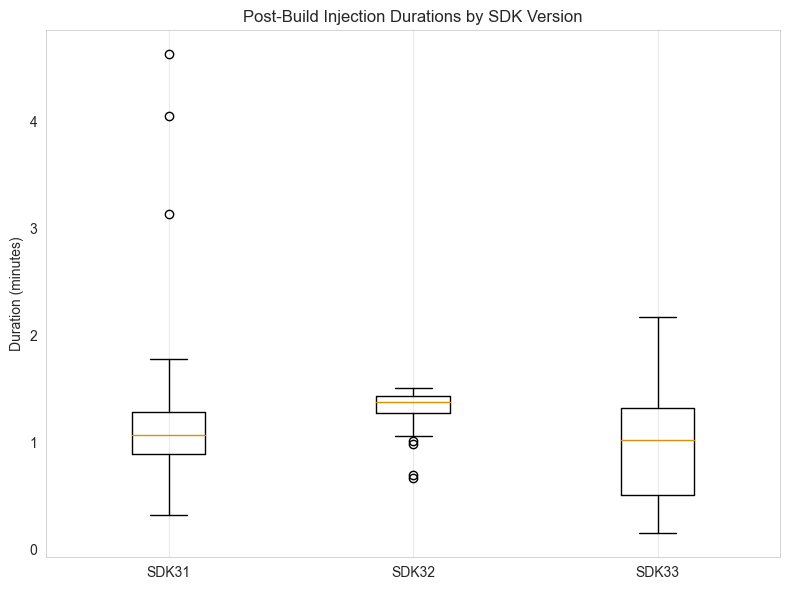

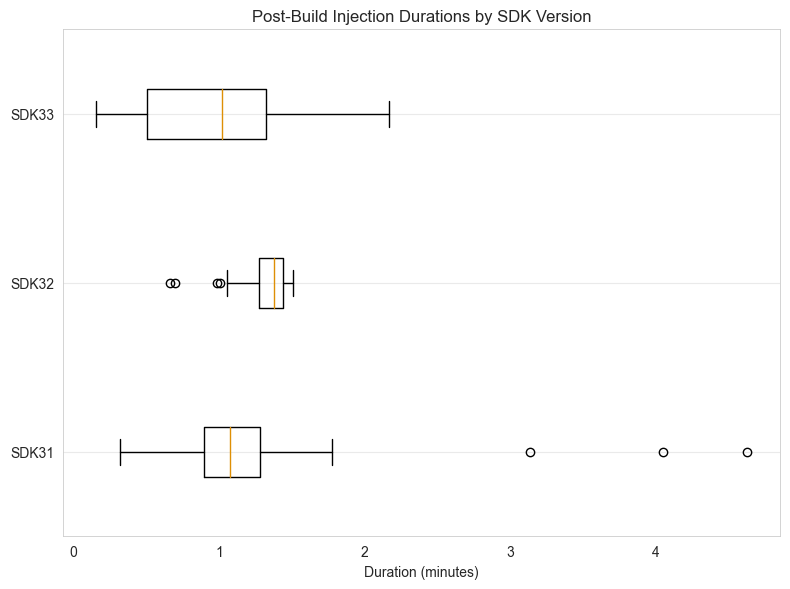

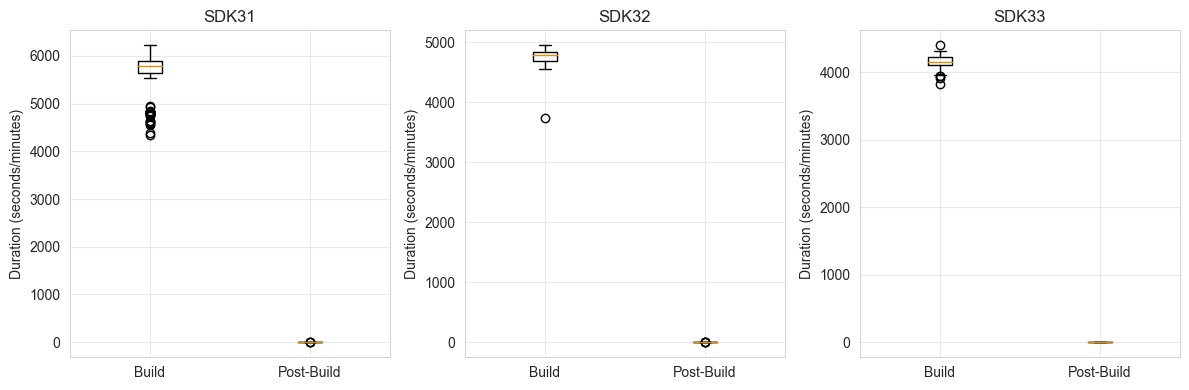

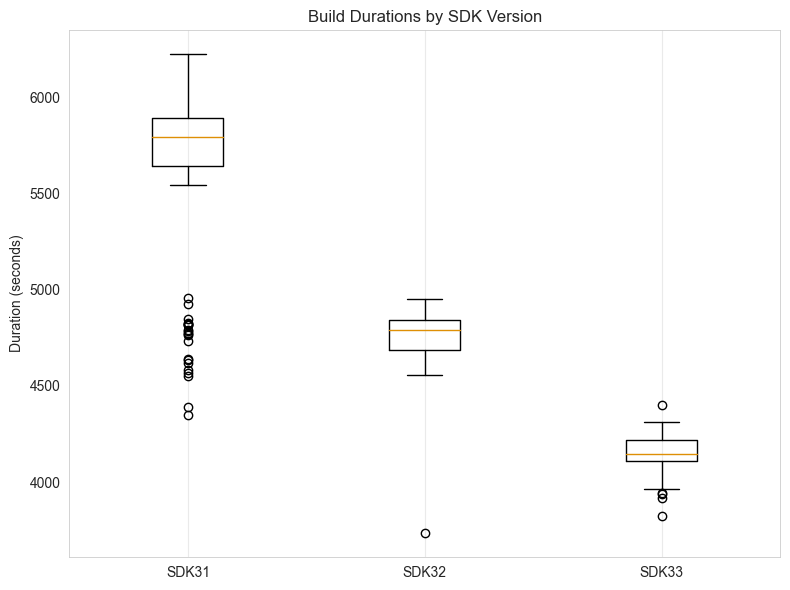

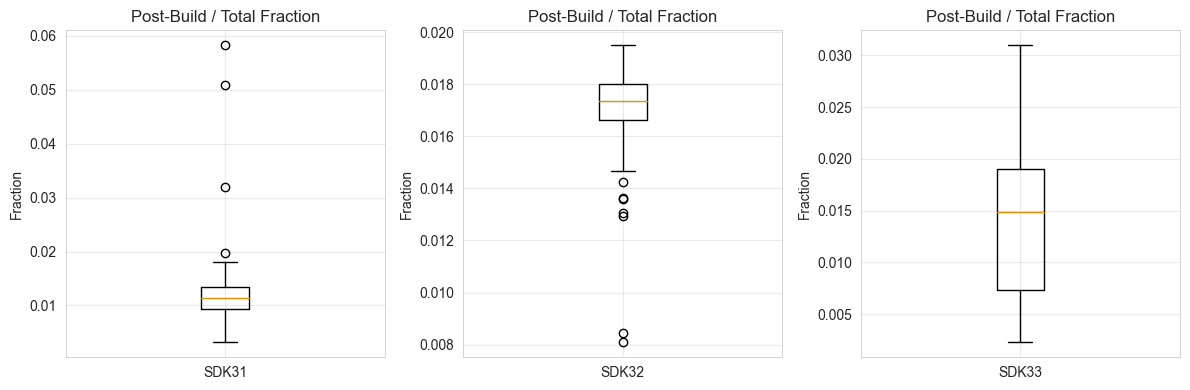

In [277]:
import json
import matplotlib.pyplot as plt

# Map Android versions to SDK labels
version_to_sdk = {
    "12": "SDK31",
    "12_1": "SDK32",
    "13": "SDK33"
}

android_version_list = ["12", "12_1", "13"]

# Prepare data containers
build_durations_all = []
post_durations_all = []
fractions_all = []

for android_version in android_version_list:
    # Load build durations
    with open(f"results_builder/{android_version}/results_build_time.json", 'r') as f:
        build_data = json.load(f)
    build_durations = [entry['duration'] for entry in build_data]
    build_durations_all.append(build_durations)

    # Load post-build durations
    with open(f"results_builder/{android_version}/results_post_build_injections.json", 'r') as f:
        post_data = json.load(f)
    post_durations = [entry['duration_minutes'] for entry in post_data]
    post_durations_all.append(post_durations)

    # Compute fractions
    build_dict = {entry['firmware_id']: entry['duration'] for entry in build_data}
    fractions = []
    for entry in post_data:
        fw_id = entry['firmware_id']
        post_duration_sec = entry['duration_seconds']
        build_duration_sec = build_dict.get(fw_id)
        if build_duration_sec and build_duration_sec > 0:
            fractions.append(post_duration_sec / build_duration_sec)
    fractions_all.append(fractions)

sdk_labels = [version_to_sdk[v] for v in android_version_list]

# --- Histograms for Build Durations ---
plt.figure(figsize=(12, 4))
for i, durations in enumerate(build_durations_all):
    plt.subplot(1, len(android_version_list), i+1)
    plt.hist(durations, bins=10, color='skyblue', edgecolor='black')
    plt.title(f'Build Durations {sdk_labels[i]}')
    plt.xlabel('Seconds')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# --- Boxplot for Post-Build Durations (minutes) ---
plt.figure(figsize=(8, 6))
plt.boxplot(post_durations_all, labels=sdk_labels)
plt.title('Post-Build Injection Durations by SDK Version')
plt.ylabel('Duration (minutes)')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# --- Horizontal Boxplot for Post-Build Durations (minutes) ---
plt.figure(figsize=(8, 6))
plt.boxplot(post_durations_all, vert=False, labels=sdk_labels)
plt.title('Post-Build Injection Durations by SDK Version')
plt.xlabel('Duration (minutes)')
plt.grid(axis='x')
plt.tight_layout()
plt.show()

# --- Boxplots for Build vs Post-Build ---
plt.figure(figsize=(12, 4))
for i, (build, post) in enumerate(zip(build_durations_all, post_durations_all)):
    plt.subplot(1, len(android_version_list), i+1)
    plt.boxplot([build, post], vert=True, labels=['Build', 'Post-Build'])
    plt.title(f'{sdk_labels[i]}')
    plt.ylabel('Duration (seconds/minutes)')
plt.tight_layout()
plt.show()

# --- Boxplot for Build Durations ---
plt.figure(figsize=(8, 6))
plt.boxplot(build_durations_all, labels=sdk_labels)
plt.title('Build Durations by SDK Version')
plt.ylabel('Duration (seconds)')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# --- Boxplots for Post-Build Fraction ---
plt.figure(figsize=(12, 4))
for i, fractions in enumerate(fractions_all):
    plt.subplot(1, len(android_version_list), i+1)
    plt.boxplot(fractions, labels=[sdk_labels[i]])
    plt.title('Post-Build / Total Fraction')
    plt.ylabel('Fraction')
plt.tight_layout()
plt.show()


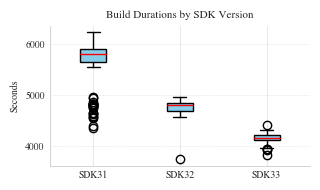

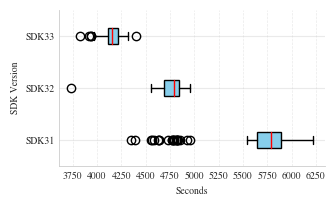

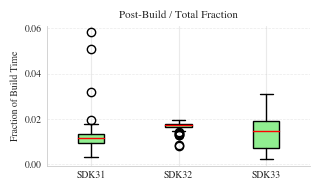

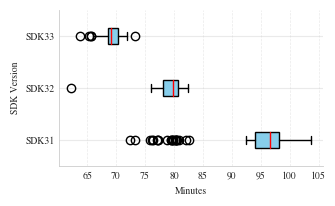

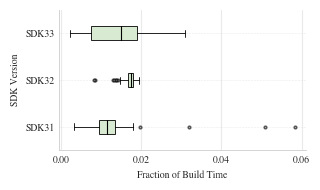

In [278]:
import json
import matplotlib.pyplot as plt
import matplotlib as mpl

# Use a clean scientific style
mpl.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times"],
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.linewidth": 0.6,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.major.size": 3,
    "ytick.major.size": 3,
    "xtick.major.width": 0.6,
    "ytick.major.width": 0.6,
    "grid.alpha": 0.4,
})


# Map Android versions to SDK labels
version_to_sdk = {
    "12": "SDK31",
    "12_1": "SDK32",
    "13": "SDK33"
}

android_version_list = ["12", "12_1", "13"]

# Prepare data container
build_durations_all = []

# Load build durations for each version
for android_version in android_version_list:
    with open(f"results_builder/{android_version}/results_build_time.json", 'r') as f:
        build_data = json.load(f)
    build_durations = [entry['duration'] for entry in build_data]
    build_durations_all.append(build_durations)

sdk_labels = [version_to_sdk[v] for v in android_version_list]

# --- Small Boxplot for Conference Paper ---
plt.figure(figsize=(3.3, 2))  # width x height in inches, fits double-column
plt.boxplot(build_durations_all, labels=sdk_labels, patch_artist=True,
            boxprops=dict(facecolor='skyblue', color='black'),
            medianprops=dict(color='red'))
plt.title('Build Durations by SDK Version', fontsize=8)
plt.ylabel('Seconds', fontsize=7)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# --- Small Boxplot for Conference Paper ---
plt.figure(figsize=(3.3, 2))  # height > width for horizontal layout
plt.boxplot(build_durations_all, labels=sdk_labels, patch_artist=True,
            vert=False,
            boxprops=dict(facecolor='skyblue', color='black'),
            medianprops=dict(color='red'))
#plt.title('Build Durations by SDK Version', fontsize=8)
plt.xlabel('Seconds', fontsize=7)
plt.ylabel('SDK Version', fontsize=7)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.locator_params(axis='x', nbins=11)  # add this line
plt.grid(axis='x', linestyle='--', linewidth=0.5)
plt.tight_layout(pad=0.5)
plt.savefig("./images/build_durations_boxplot.pdf", format='pdf', bbox_inches='tight')
plt.show()

plt.figure(figsize=(3.3, 2))  # width x height in inches for single-column
plt.boxplot(fractions_all, labels=sdk_labels, patch_artist=True,
            boxprops=dict(facecolor='lightgreen', color='black'),
            medianprops=dict(color='red'))
plt.title('Post-Build / Total Fraction', fontsize=8)
plt.ylabel('Fraction of Build Time', fontsize=7)  # updated label
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# Duration in Minutes boxplot
build_durations_all_minutes = [[x / 60 for x in sublist] for sublist in build_durations_all]
plt.figure(figsize=(3.3, 2))
plt.boxplot(build_durations_all_minutes, labels=sdk_labels, patch_artist=True,
            vert=False,
            boxprops=dict(facecolor='skyblue', color='black'),
            medianprops=dict(color='red'))

#plt.title('Build Durations by SDK Version', fontsize=8)
plt.xlabel('Minutes', fontsize=7)  # <-- changed label
plt.ylabel('SDK Version', fontsize=7)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.locator_params(axis='x', nbins=11)  # add this line
plt.grid(axis='x', linestyle='--', linewidth=0.5)
plt.tight_layout(pad=0.5)
plt.savefig("./images/build_durations_boxplot.pdf", format='pdf', bbox_inches='tight')
plt.show()



plt.figure(figsize=(3.3, 2))  # width x height in inches for single-column

# Create horizontal boxplot
plt.boxplot(
    fractions_all,
    labels=sdk_labels,
    patch_artist=True,
    vert=False,
    boxprops=dict(facecolor="#D8EAD2", linewidth=0.6),
    medianprops=dict(color="black", linewidth=0.8),
    whiskerprops=dict(linewidth=0.6),
    capprops=dict(linewidth=0.6),
    flierprops=dict(marker="o", markersize=2, markerfacecolor="grey", alpha=0.6),
)

# Axis labels
plt.xlabel("Fraction of Build Time", fontsize=7)
plt.ylabel("SDK Version", fontsize=7)

# Tick formatting
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.grid(axis="y", linestyle="--", linewidth=0.4)

# Tight layout for LaTeX export
plt.tight_layout()

# Save for paper inclusion
plt.savefig(
    "./images/post_build_durations_boxplot.pdf",
    format="pdf",
    bbox_inches="tight",
)
plt.show()

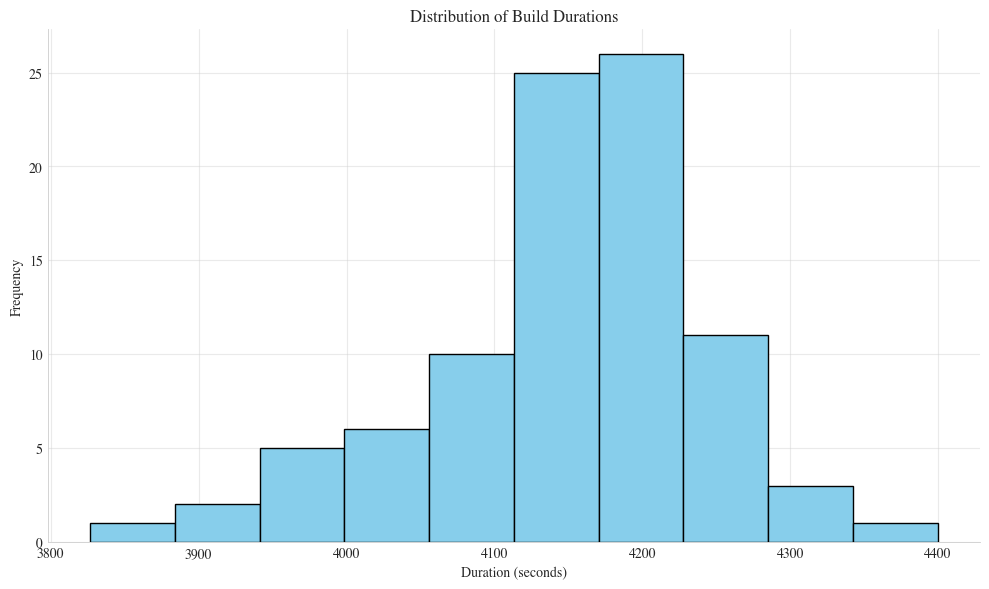

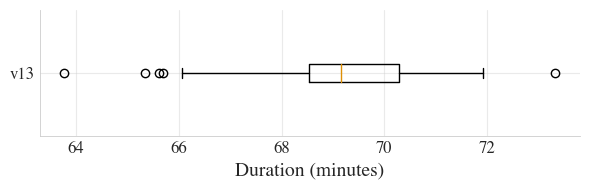

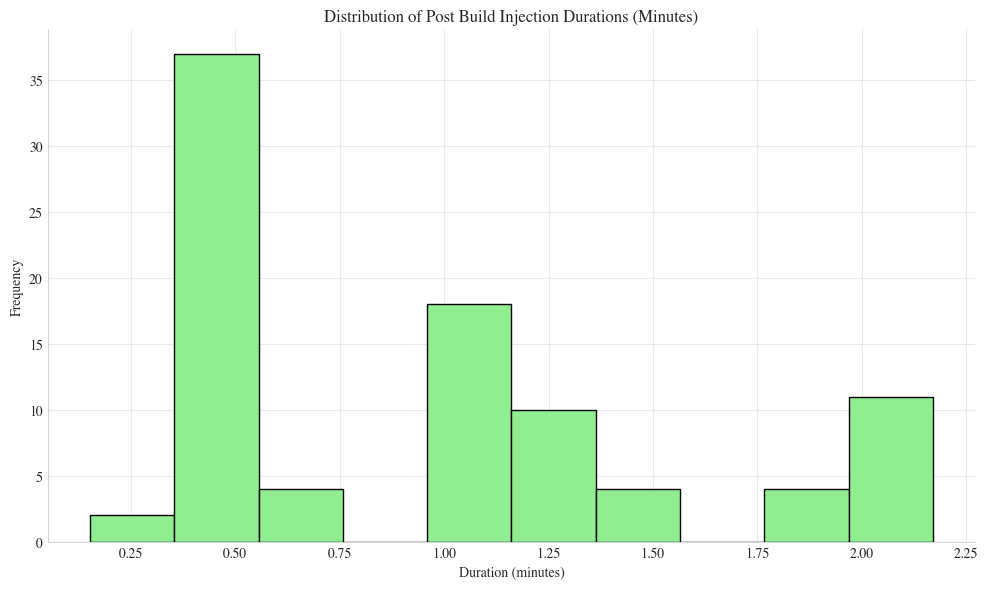

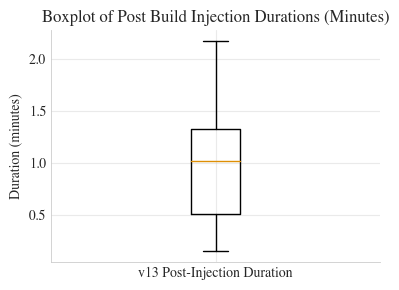

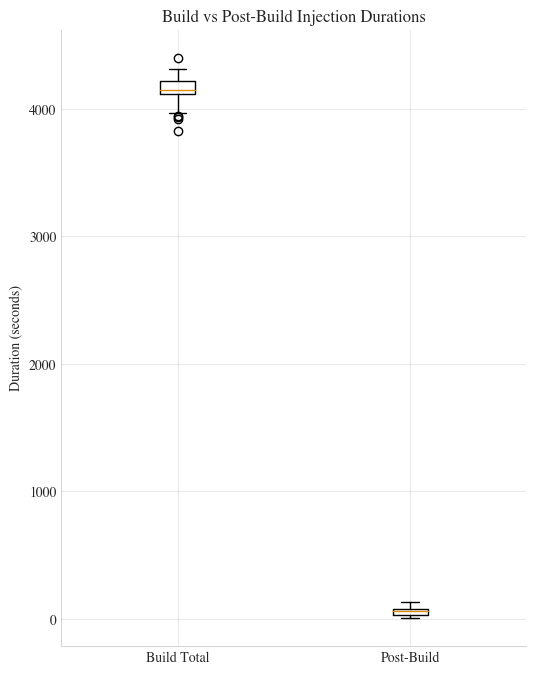

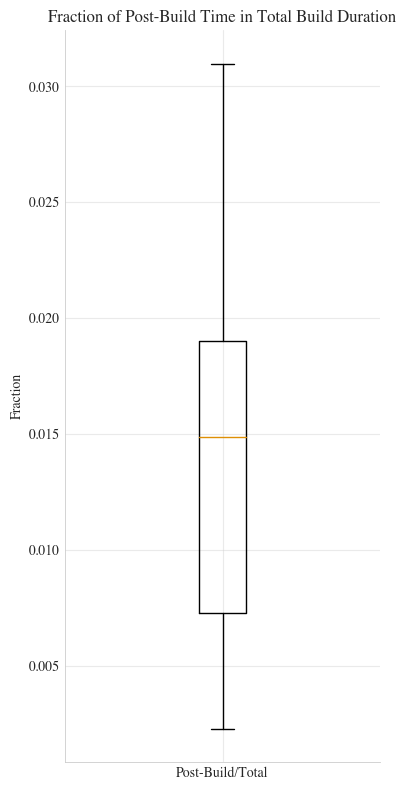

In [279]:
import json
import matplotlib.pyplot as plt


# Set here the version to read the data from
android_version_list = ["12", "12_1", "13"]

with open(f"results_builder/{android_version}/results_build_time.json", 'r') as f:
    data = json.load(f)

# Extract durations
durations_sec = [entry['duration'] for entry in data]
durations_min = [d / 60 for d in durations_sec]

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(durations_sec, bins=10, color='skyblue', edgecolor='black')
plt.title('Distribution of Build Durations')
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 2))
plt.boxplot(durations_min, vert=False, labels=[f"v{android_version}"])
plt.xlabel('Duration (minutes)', fontsize=14)
plt.tick_params(axis='both', labelsize=12)
plt.tight_layout()
plt.savefig(f"images/v{android_version}_Duration_Builds.pdf")
plt.show()

# Load the data
with open(f"results_builder/{android_version}/results_post_build_injections.json", 'r') as f:
    data = json.load(f)

# Extract duration_minutes
duration_minutes = [entry['duration_minutes'] for entry in data]

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(duration_minutes, bins=10, color='lightgreen', edgecolor='black')
plt.title('Distribution of Post Build Injection Durations (Minutes)')
plt.xlabel('Duration (minutes)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Plot boxplot (vertical)
plt.figure(figsize=(4, 3))
plt.boxplot(duration_minutes, vert=True, labels=[f"v{android_version} Post-Injection Duration"])
plt.title('Boxplot of Post Build Injection Durations (Minutes)')
plt.ylabel('Duration (minutes)')
plt.tight_layout()
plt.savefig(f"images/v{android_version}_Duration_Post_Injection.pdf")
plt.show()

# Load build durations
with open(f"results_builder/{android_version}/results_build_time.json", 'r') as f:
    build_data = json.load(f)
build_durations = [entry['duration'] for entry in build_data]

# Load post-build injection durations
with open(f"results_builder/{android_version}/results_post_build_injections.json", 'r') as f:
    post_data = json.load(f)
post_durations = [entry['duration_seconds'] for entry in post_data]

# Plot both in one boxplot
plt.figure(figsize=(6, 8))
plt.boxplot([build_durations, post_durations], vert=True, labels=['Build Total', 'Post-Build'])
plt.title('Build vs Post-Build Injection Durations')
plt.ylabel('Duration (seconds)')

# Load build durations
with open(f"results_builder/{android_version}/results_build_time.json", 'r') as f:
    build_data = json.load(f)
build_dict = {entry['firmware_id']: entry['duration'] for entry in build_data}

# Load post-build durations
with open(f"results_builder/{android_version}/results_post_build_injections.json", 'r') as f:
    post_data = json.load(f)

fractions = []
for entry in post_data:
    fw_id = entry['firmware_id']
    post_duration = entry['duration_seconds']
    build_duration = build_dict.get(fw_id)
    if build_duration and build_duration > 0:
        fractions.append(post_duration / build_duration)

plt.figure(figsize=(4, 8))
plt.boxplot(fractions, vert=True, labels=['Post-Build/Total'])
plt.title('Fraction of Post-Build Time in Total Build Duration')
plt.ylabel('Fraction')
plt.tight_layout()
plt.show()

# Sanity Check and Coverage Ratios

Sanity check List 13: 86
Eval Set size: 86
Samples in database that are not yet evaluated: 0
in_other_set: {'12': [], '12_1': [], '13': []}
86
86
0.4233578883308589
0.42


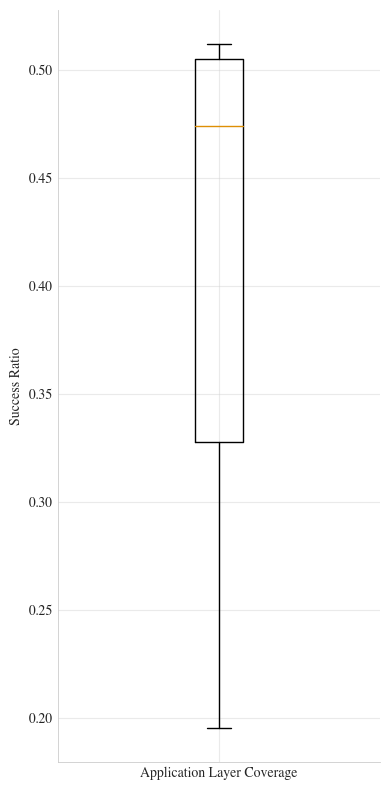

In [280]:
import json
import matplotlib.pyplot as plt

# We have more samples in the database that could be evaluated. This are the samples used and evaluated.
sanity_check_list_31 = [
"68b15b6465e2ad36cf48b552",
"68b1793565e2ad36cf60abb1",
"68b1888f65e2ad36cf6d98fa",
"68b17c4d65e2ad36cf638567",
"68af388565e2ad36cf94dea9",
"68af219965e2ad36cf8260b2",
"68af169465e2ad36cf7871b7",
"68af163465e2ad36cf783058",
"68af110965e2ad36cf7475cd",
"68af527e65e2ad36cfab0359",
"68af426d65e2ad36cf9f9ae2",
"68af271f65e2ad36cf87f7a9",
"68af42df65e2ad36cf9fe2e2",
"68af4a2965e2ad36cfa4c3a7",
"68af2f0565e2ad36cf8ec78b",
"68af2c8865e2ad36cf8d7c82",
"68b15b6465e2ad36cf48b552",
"68af568b65e2ad36cfae4ae0",
"68b1793565e2ad36cf60abb1",
"68b1888f65e2ad36cf6d98fa",
"68b17c4d65e2ad36cf638567",
"68b1f86e65e2ad36cfc530f4",
"68b1ed3065e2ad36cfbc8252",
"68b1e23b65e2ad36cfb6228a",
"68b1e6f865e2ad36cfb85aaa",
"68b1e4e565e2ad36cfb762a4",
"68b1ded465e2ad36cfb277ba",
"68b1d66d65e2ad36cfab3c34",
"68b1c52865e2ad36cf9fb03c",
"68b1c01965e2ad36cf9bafcb",
"68b1a3cf65e2ad36cf82f526",
"68b2204865e2ad36cfe48dc0",
"68b2052365e2ad36cfce85f6",
"68b2019e65e2ad36cfcce612",
"68b213fd65e2ad36cfdce54e",
"68b22e4b65e2ad36cfef9738",
"68b21be565e2ad36cfe0cf20",
"68b1feae65e2ad36cfcad9f6",
"68b2885865e2ad36cf3631fa",
"68b2717f65e2ad36cf245d69",
"68b280f165e2ad36cf2f0786",
"68b266e865e2ad36cf1a5cbb",
"68b29f1365e2ad36cf45aa06",
"68b26d9c65e2ad36cf21d030",
"68b2b35565e2ad36cf550d2e",
"68b2b50d65e2ad36cf56065c",
"68b2a87f65e2ad36cf4bc02d",
"68b3190265e2ad36cf9ee70a",
"68b30f0b65e2ad36cf9a5278",
"68b2ff7a65e2ad36cf8d5b72",
"68b2f11665e2ad36cf82835f",
"68b2f4a665e2ad36cf85276f",
"68b2ebc265e2ad36cf7e81e2",
"68b2e6d065e2ad36cf7a8b46",
"68b2daf965e2ad36cf70b0e5",
"68b2d78b65e2ad36cf6dd3ad",
"68b2c67765e2ad36cf60f6d4",
"68af5a9765e2ad36cfb14a36",
"68af64ac65e2ad36cfbb02d6",
"68af7c2965e2ad36cfcd1488",
"68af7f6065e2ad36cfcfb4bc",
"68afbec865e2ad36cf05f3b3",
"68b0aca965e2ad36cfc2478d",
"68b0bb2b65e2ad36cfcb8e24",
"68b1075d65e2ad36cf0776d5",
"68b10b9365e2ad36cf09d98f",
"68b1266865e2ad36cf200744",
"68b134be65e2ad36cf2b556f",
"68aff32465e2ad36cf30b876",
"68b012c465e2ad36cf49c406",
"68b04b0965e2ad36cf761c59",
"68b0705165e2ad36cf97ab46",
"68b0892a65e2ad36cfab2516",
"68b0927165e2ad36cfb0b56a",
"68b0da2165e2ad36cfe19b3d",
"68b24edf65e2ad36cf088805",
"68b24fb565e2ad36cf090495",
]

sanity_check_list_32 = [
"68b014e565e2ad36cf4b16c5",
"68b00a1665e2ad36cf430442",
"68afc71965e2ad36cf0c4584",
"68afa63065e2ad36cff0e277",
"68af0f3e65e2ad36cf732fc8",
"68af0f0865e2ad36cf731949",
"68b0650765e2ad36cf8e8100",
"68b0f76c65e2ad36cffc4271",
"68b1cdb665e2ad36cfa30dbb",
"68b13c0765e2ad36cf3046f8",
"68b1d3db65e2ad36cfa89938",
"68b1f27165e2ad36cfc1979b",
"68b15e7865e2ad36cf4b1435",
"68b200c865e2ad36cfcc7b51",
"68b214e665e2ad36cfdd617a",
"68b1259c65e2ad36cf1f93fb",
"68b1577465e2ad36cf46a434",
"68b2234d65e2ad36cfe68aa8",
"68b308e265e2ad36cf948f21",
"68b240b465e2ad36cfff9375",
"68b231bb65e2ad36cff19010",
"68b25dc465e2ad36cf15ce8d",
"68b2e79465e2ad36cf7b303e",
"68b2c8b265e2ad36cf61f56b",
"68b2bc4c65e2ad36cf594a18"
]

sanity_check_list_33 = [
"68b2854765e2ad36cf33d7dc",
"68b299b765e2ad36cf432532",
"68b28f6765e2ad36cf394c2f",
"68b28d5565e2ad36cf38dfdf",
"68b28b8c65e2ad36cf38293e",
"68b27c2065e2ad36cf2b5430",
"68b27aae65e2ad36cf2a889b",
"68b29ed965e2ad36cf45a9f3",
"68b29ca965e2ad36cf45439d",
"68b2dddd65e2ad36cf725c75",
"68b2d05965e2ad36cf68ce09",
"68b2d1b465e2ad36cf69cf29",
"68b2c14b65e2ad36cf5cb908",
"68b2c5d965e2ad36cf60a5ec",
"68b2b8c065e2ad36cf580595",
"68b2acdc65e2ad36cf4f8df8",
"68b193d065e2ad36cf746921",
"68b19fde65e2ad36cf8152a6",
"68b19cbf65e2ad36cf7edd2b",
"68b18ff965e2ad36cf732dae",
"68b18d6a65e2ad36cf71fe7f",
"68b1f46d65e2ad36cfc2b644",
"68b1d7e965e2ad36cfac1b94",
"68b1ca1565e2ad36cfa1d0cb",
"68b1c64865e2ad36cfa04164",
"68b1bd6665e2ad36cf99af39",
"68b1b77565e2ad36cf931cd2",
"68b1b24065e2ad36cf8e4224",
"68b1b01765e2ad36cf8c9c44",
"68b1acf665e2ad36cf895da8",
"68b1a71465e2ad36cf84559b",
"68b1a0c365e2ad36cf81c604",
"68b2627765e2ad36cf175dcc",
"68b2485865e2ad36cf039faa",
"68b2729d65e2ad36cf24c952",
"68b2428d65e2ad36cf00aa83",
"68b2270d65e2ad36cfe8200a",
"68b2241e65e2ad36cfe6cd31",
"68b2110f65e2ad36cfdb0c99",
"68b2063f65e2ad36cfceb9a2",
"68b277a165e2ad36cf27f2c3",
"68b237ab65e2ad36cff6510d",
"68b26eda65e2ad36cf22e5f5",
"68b25e3865e2ad36cf15e0a0",
"68b23e6f65e2ad36cffd75d6",
"68b22d7f65e2ad36cfeef127",
"68b0bdb265e2ad36cfcc7df6",
"68b0d4f765e2ad36cfde5327",
"68b0c70365e2ad36cfd45afb",
"68b0ce9465e2ad36cfdae651",
"68b0c9e365e2ad36cfd6fa1f",
"68b0ef8a65e2ad36cff412c6",
"68b0e79365e2ad36cfed6aa2",
"68b0e44f65e2ad36cfec484d",
"68b0e36b65e2ad36cfebb39e",
"68b0e09f65e2ad36cfe94aa8",
"68b0e6f765e2ad36cfed6286",
"68b0d35e65e2ad36cfddbbec",
"68b1469665e2ad36cf39d93d",
"68b1338465e2ad36cf2a5ae3",
"68b1293165e2ad36cf21dcb1",
"68b1170965e2ad36cf1480f1",
"68b1082065e2ad36cf07c3f4",
"68b1047765e2ad36cf052732",
"68b1376a65e2ad36cf2ce047",
"68b1155d65e2ad36cf131440",
"68b140d165e2ad36cf3557e4",
"68b12c1e65e2ad36cf2381e4",
"68b11be465e2ad36cf17128b",
"68b10e1c65e2ad36cf0b8552",
"68b0fd7065e2ad36cffedf74",
"68b0f77465e2ad36cffc440d",
"68b0f59965e2ad36cffaf2db",
"68b1829365e2ad36cf680cb8",
"68b1681265e2ad36cf53b5e0",
"68b1754e65e2ad36cf5e2ee3",
"68b1749b65e2ad36cf5da111",
"68b166aa65e2ad36cf52cd3a",
"68b164e565e2ad36cf515210",
"68b17f9565e2ad36cf65ac12",
"68b16e0a65e2ad36cf5756cf",
"68b16c7665e2ad36cf565072",
"68b15f1365e2ad36cf4b42e7",
"68b14e5665e2ad36cf3ff0f0",
"68b14ca665e2ad36cf3eb2d2",
"68b18d1765e2ad36cf71efd3",
]

def remove_duplicates_by_firmware_id(data):
    unique = {}
    for item in data:
        fid = item['firmware_id']
        if fid not in unique:
            unique[fid] = item
    return list(unique.values())

# Load the data
with open(f"results_builder/{android_version}/results_post_build_injections.json", 'r') as f:
    post_data = json.load(f)
    post_data = remove_duplicates_by_firmware_id(post_data)

with open(f"results_builder/{android_version}/results_build_injection.json", 'r') as f:
    pre_data = json.load(f)
    pre_data = remove_duplicates_by_firmware_id(pre_data)


ratios = []
not_in_list = []
in_list = []
in_other_set = {"12":[], "12_1":[], "13":[]}

if android_version == "12":
    sanity_check_list = sanity_check_list_31
    print(f"Sanity check List 12: {len(sanity_check_list)}")
elif android_version == "12_1":
    sanity_check_list = sanity_check_list_32
    print(f"Sanity check List 12_1: {len(sanity_check_list)}")
elif android_version == "13":
    sanity_check_list = sanity_check_list_33
    print(f"Sanity check List 13: {len(sanity_check_list)}")
else:
    raise ValueError("Invalid android version")

for entry in post_data:
    #print(f"Processing {entry['firmware_id']}")
    if not entry["firmware_id"] in sanity_check_list:
        print(f"Not in list {entry['firmware_id']} skipping.")
        not_in_list.append(entry["firmware_id"])
        if entry["firmware_id"] in sanity_check_list_31 or entry["firmware_id"] in sanity_check_list_32 or entry["firmware_id"] in sanity_check_list_33:
            print(f"Firmware found in other set.")
            in_other_set[android_version].append(entry["firmware_id"])
        continue
    else:
        in_list.append(entry["firmware_id"])
    pre_build_entry = next((item for item in pre_data if item['firmware_id'] == entry['firmware_id']), None)
    app_count = 0
    libs_count = 0
    if pre_build_entry:
        app_count = len(pre_build_entry["included_package_statistics"]["apps"])
        libs_count = len(pre_build_entry["included_package_statistics"]["libs"])

    indirect_injection_count = entry["objects_injected"]
    direct_injection = entry["partition_files_injected"]
    number_of_files_post_injected = entry["files_injected"]

    total_files_injected = number_of_files_post_injected + app_count + libs_count
    error_count = entry["errors"] - app_count - libs_count
    total_number_of_files = number_of_files_post_injected + error_count
    if total_number_of_files > 0:
        ratios.append(number_of_files_post_injected / total_number_of_files)

print(f"Eval Set size: {len(in_list)}")
print(f"Samples in database that are not yet evaluated: {len(not_in_list)}")
print(f"in_other_set: {in_other_set}")
print(len(pre_data))
print(len(post_data))
overall_average = sum(ratios) / len(ratios) if ratios else 0
print(overall_average)
rounded_value = round(overall_average, 2)
print(rounded_value)

plt.figure(figsize=(4, 8))
plt.boxplot(ratios, vert=True, labels=['Application Layer Coverage'])
#plt.title('Boxplot of Files Injected / Files Total')
plt.ylabel('Success Ratio')
plt.tight_layout()
plt.show()

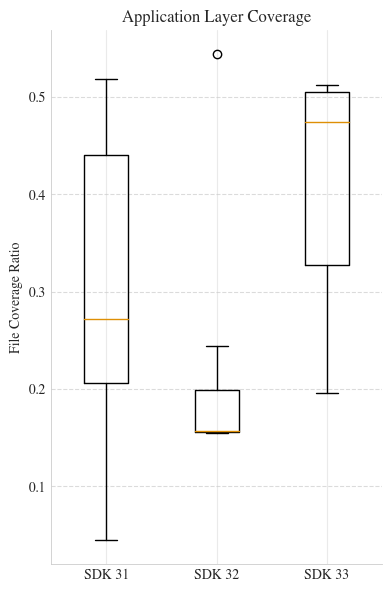

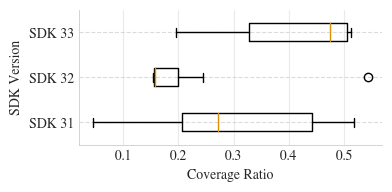

In [281]:
import json
import matplotlib.pyplot as plt

android_version_list = ["12", "12_1", "13"]

# Mapping Android versions to SDK versions
android_to_sdk = {
    "12": 31,
    "12_1": 32,
    "13": 33
}

# Assume sanity_check_list_31, sanity_check_list_32, sanity_check_list_33 exist
sanity_check_dict = {
    "12": sanity_check_list_31,
    "12_1": sanity_check_list_32,
    "13": sanity_check_list_33
}

def remove_duplicates_by_firmware_id(data):
    unique = {}
    for item in data:
        fid = item['firmware_id']
        if fid not in unique:
            unique[fid] = item
    return list(unique.values())

ratios_per_version = []

for android_version in android_version_list:
    with open(f"results_builder/{android_version}/results_post_build_injections.json", 'r') as f:
        post_data = json.load(f)
        post_data = remove_duplicates_by_firmware_id(post_data)

    with open(f"results_builder/{android_version}/results_build_injection.json", 'r') as f:
        pre_data = json.load(f)
        pre_data = remove_duplicates_by_firmware_id(pre_data)

    ratios = []
    sanity_check_list = sanity_check_dict[android_version]

    for entry in post_data:
        if entry["firmware_id"] not in sanity_check_list:
            continue

        pre_build_entry = next((item for item in pre_data if item['firmware_id'] == entry['firmware_id']), None)
        app_count = len(pre_build_entry["included_package_statistics"]["apps"]) if pre_build_entry else 0
        libs_count = len(pre_build_entry["included_package_statistics"]["libs"]) if pre_build_entry else 0

        number_of_files_post_injected = entry["files_injected"]
        error_count = entry["errors"] - app_count - libs_count
        total_number_of_files = number_of_files_post_injected + error_count

        if total_number_of_files > 0:
            ratios.append(number_of_files_post_injected / total_number_of_files)

    ratios_per_version.append(ratios)

# Use SDK versions for boxplot labels
sdk_labels = [f"SDK {android_to_sdk[v]}" for v in android_version_list]

plt.figure(figsize=(4, 6))
plt.boxplot(ratios_per_version, labels=sdk_labels, widths=0.4)
plt.ylabel('File Coverage Ratio')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Application Layer Coverage', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout(pad=1)
plt.show()


plt.figure(figsize=(4, 2))
plt.boxplot(ratios_per_version, labels=sdk_labels, widths=0.4, vert=False)
plt.ylabel('SDK Version')
plt.xlabel('Coverage Ratio')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
#plt.title('Application Layer Coverage', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout(pad=1)
plt.savefig("./images/coverage_ratios.pdf", format='pdf', bbox_inches='tight')
plt.show()